In [ ]:
import pandas as pd
import os

csv_path = "/content/drive/My Drive/FracAtlas/dataset.csv"
df = pd.read_csv(csv_path)

base_path = "/content/drive/My Drive/FracAtlas/images"

def get_full_path(row):
    folder = "Fractured" if row['fractured'] == 1 else "Non_fractured"
    return os.path.join(base_path, folder, row['image_id'])

df['image_path'] = df.apply(get_full_path, axis=1)

df['label'] = df['fractured']

# Quick check
print("Total rows:", len(df))
print(df[['image_path', 'label']].head())


Total rows: 4083
                                          image_path  label
0  /content/drive/My Drive/FracAtlas/images/Non_f...      0
1  /content/drive/My Drive/FracAtlas/images/Non_f...      0
2  /content/drive/My Drive/FracAtlas/images/Non_f...      0
3  /content/drive/My Drive/FracAtlas/images/Non_f...      0
4  /content/drive/My Drive/FracAtlas/images/Non_f...      0


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df[['image_path', 'label']],
    test_size=0.15,
    stratify=df['label'],
    random_state=42
)

print("Val samples:", len(val_df))


Val samples: 613


In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = (224, 224)

def load_image_safe(path, label):
    def _load(path_str):
        path_str = path_str.numpy().decode('utf-8')
        img = Image.open(path_str).convert('RGB')
        img = img.resize(IMG_SIZE)
        img = np.array(img)
        img = preprocess_input(img)
        return img.astype(np.float32)

    image = tf.py_function(_load, [path], tf.float32)
    image.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    label = tf.cast(label, tf.float32)
    return image, label


In [ ]:
BATCH_SIZE = 32

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df['image_path'].values, val_df['label'].values)
)

val_ds = val_ds.map(load_image_safe, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
model_save_path = "/content/drive/MyDrive/Colab Notebooks/Faizan.keras"
from tensorflow.keras.models import load_model

loaded_model = load_model(model_save_path)
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
def extract_primary_hotspot(heatmap, threshold=0.6, min_area=150):
    """
    Extracts only the SINGLE highest-activation region in the heatmap.
    """
    # Normalize
    heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # Binary mask
    mask = (heatmap_norm > threshold).astype(np.uint8) * 255

    # Find all contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None, None

    # Pick the *largest* high-activation region
    largest = max(contours, key=cv2.contourArea)

    if cv2.contourArea(largest) < min_area:
        return None, None

    x, y, w, h = cv2.boundingRect(largest)
    return (x, y, w, h), mask


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def extract_fracture_region(heatmap, orig_img, threshold=0.65, min_area=50):
    """
    Extracts ONLY the highest activation fracture region.
    Returns:
        mask_only  - isolated fracture region
        boxed_img  - image with bounding box
    """

    # Normalize heatmap to 0-1
    heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    # Threshold on highest activations
    mask_bin = (heatmap_norm > threshold).astype(np.uint8) * 255

    # Find contours
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return np.zeros_like(orig_img), orig_img

    # Largest contour = fracture area
    largest = max(contours, key=cv2.contourArea)

    if cv2.contourArea(largest) < min_area:
        return np.zeros_like(orig_img), orig_img

    x, y, w, h = cv2.boundingRect(largest)

    # Build mask (fracture only)
    mask_only = np.zeros_like(orig_img, dtype=np.uint8)
    mask_only[y:y+h, x:x+w] = orig_img[y:y+h, x:x+w]

    # Draw bounding box
    boxed_img = orig_img.copy()
    cv2.rectangle(boxed_img, (x, y), (x+w, y+h), (255, 0, 0), 3)

    return mask_only, boxed_img


In [ ]:
def predict_image_with_gradcam(model, image_path, last_conv_layer_name="top_conv"):
    img_size = (224, 224)

    # Load & preprocess image
    img = Image.open(image_path).convert('RGB')
    img_resized = img.resize(img_size)
    img_array = np.array(img_resized)
    processed = preprocess_input(img_array.astype(np.float32))
    processed = np.expand_dims(processed, axis=0)

    # Prediction
    prob = model.predict(processed)[0][0]
    label = "Fracture" if prob > 0.5 else "Non-fracture"

    # Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(processed, model, last_conv_layer_name)

    # Resize heatmap to ORIGINAL image
    heatmap_resized = cv2.resize(heatmap, (img.size[0], img.size[1]))

    # Extract fracture area ONLY
    mask_only, boxed_img = extract_fracture_region(
        heatmap_resized,
        np.array(img),
        threshold=0.65  # adjust if needed
    )

    # Display results
    plt.figure(figsize=(16,6))

    plt.subplot(1,3,1)
    plt.imshow(mask_only)
    plt.title("Fracture Region Only")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(boxed_img)
    plt.title("Detected Fracture (Boxed)")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(img)
    plt.title(f"Original: {label} ({prob:.3f})")
    plt.axis('off')

    plt.show()

    return prob, label, mask_only, boxed_img


In [ ]:
image_path = "/content/drive/MyDrive/FracAtlas/images/Fractured/IMG0003519.jpg"

prob, label, heatmap, overlay = predict_image_with_gradcam(
    loaded_model,
    image_path,
    last_conv_layer_name="top_conv"
)

print(f"Prediction: {label} ({prob:.3f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_2']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


TypeError: 'module' object is not callable

In [ ]:
model_save_path = "/content/drive/MyDrive/Colab Notebooks/Faizan.keras"
from tensorflow.keras.models import load_model

loaded_model = load_model(model_save_path)
print("Model loaded successfully!")


import tensorflow as tf
from PIL import Image
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

IMG_SIZE = (224, 224)

def load_image_safe(path, label):
    def _load(path_str):
        path_str = path_str.numpy().decode('utf-8')
        img = Image.open(path_str).convert('RGB')
        img = img.resize(IMG_SIZE)
        img = np.array(img)
        img = preprocess_input(img)
        return img.astype(np.float32)

    image = tf.py_function(_load, [path], tf.float32)
    image.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    label = tf.cast(label, tf.float32)
    return image, label


def extract_primary_hotspot(heatmap, threshold=0.6, min_area=150):

    heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    mask = (heatmap_norm > threshold).astype(np.uint8) * 255

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None, None

    largest = max(contours, key=cv2.contourArea)

    if cv2.contourArea(largest) < min_area:
        return None, None

    x, y, w, h = cv2.boundingRect(largest)
    return (x, y, w, h), mask



def extract_fracture_region(heatmap, orig_img):

    heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    thresh_value = np.percentile(heatmap_norm, 92)
    mask = (heatmap_norm >= thresh_value).astype(np.uint8) * 255

    kernel = np.ones((7, 7), np.uint8)
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return orig_img

    largest = max(contours, key=cv2.contourArea)

    x, y, w, h = cv2.boundingRect(largest)

    shrink = 0.05
    x = int(x + w * shrink)
    y = int(y + h * shrink)
    w = int(w * (1 - 2 * shrink))
    h = int(h * (1 - 2 * shrink))

    boxed_img = orig_img.copy()
    cv2.rectangle(boxed_img, (x, y), (x + w, y + h), (0, 0, 255), 3)

    return boxed_img


def predict_image_with_gradcam_combined(model, image_path, last_conv_layer_name="top_conv"):

    img = Image.open(image_path).convert('RGB')
    img_resized = img.resize((224,224))
    img_array = np.array(img_resized)
    processed = preprocess_input(img_array.astype(np.float32))
    processed = np.expand_dims(processed, axis=0)

    prob = model.predict(processed)[0][0]
    label = "Fracture" if prob > 0.5 else "Non-fracture"

    heatmap = make_gradcam_heatmap(processed, model, last_conv_layer_name)
    heatmap_resized = cv2.resize(heatmap, (img.size[0], img.size[1]))

    boxed_img = extract_fracture_region(heatmap_resized, np.array(img))
    cv2.putText(boxed_img, f"{label} ({prob:.2f})", (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 0), 3)

    orig_img_array = np.array(img)
    combined = np.concatenate((orig_img_array, boxed_img), axis=1)

    plt.figure(figsize=(12,6))
    plt.imshow(combined)
    plt.axis('off')
    plt.show()

    return prob, label, combined

Model loaded successfully!


In [ ]:
image_path = "/content/drive/MyDrive/FracAtlas/images/Fractured/IMG0003519.jpg"

prob, label, combined_img = predict_image_with_gradcam_combined(
    loaded_model,
    image_path,
    last_conv_layer_name="top_conv"
)

print(f"Prediction: {label} ({prob:.3f})")


In [10]:
model_save_path = "/content/drive/MyDrive/Colab Notebooks/Faizan.keras"
from tensorflow.keras.models import load_model

loaded_model = load_model(model_save_path)
print("Model loaded successfully!")


import tensorflow as tf
from PIL import Image
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):

    last_conv_layer = model.get_layer(last_conv_layer_name)

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (np.max(heatmap) + 1e-8)

    return heatmap


def extract_fracture_region(heatmap, orig_img):

    heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    thresh_value = np.percentile(heatmap_norm, 92)
    mask = (heatmap_norm >= thresh_value).astype(np.uint8) * 255

    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return orig_img

    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)

    boxed = orig_img.copy()
    cv2.rectangle(boxed, (x, y), (x+w, y+h), (255, 0, 0), 3)

    return boxed


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_image_with_gradcam_combined(model, image_path, last_conv_layer_name="top_conv"):

    img = Image.open(image_path).convert('RGB')
    orig_w, orig_h = img.size

    img_resized = img.resize((224,224))
    img_array = np.array(img_resized)
    processed = preprocess_input(img_array.astype(np.float32))
    processed = np.expand_dims(processed, axis=0)

    prob = model.predict(processed)[0][0]
    label = "Fracture" if prob > 0.5 else "Non-fracture"

    if label == "Non-fracture":
        orig = np.array(img).copy()
        cv2.putText(orig, "No fracture detected", (10, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,255,0), 3)
        cv2.putText(orig, f"Probability: {prob:.2f}", (10, 80),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2)

        plt.figure(figsize=(7,7))
        plt.imshow(orig)
        plt.axis('off')
        plt.show()

        return prob, label, orig

    heatmap = make_gradcam_heatmap(processed, model, last_conv_layer_name)
    heatmap_resized = cv2.resize(heatmap, (orig_w, orig_h))

    boxed_img = extract_fracture_region(heatmap_resized, np.array(img))

    cv2.putText(boxed_img, f"{label} ({prob:.2f})", (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,0), 3)

    combined = np.concatenate((np.array(img), boxed_img), axis=1)

    plt.figure(figsize=(14,6))
    plt.imshow(combined)
    plt.axis('off')
    plt.show()

    return prob, label, combined



Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


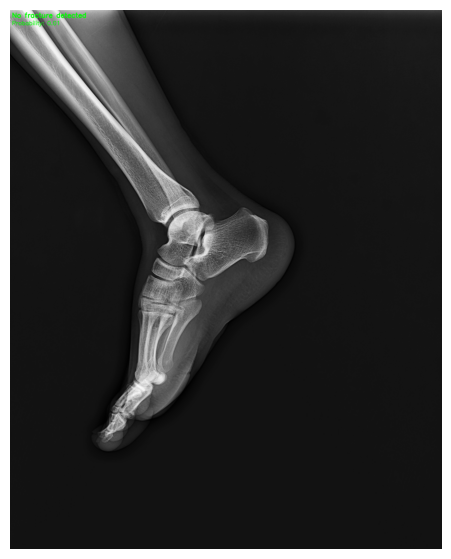

Prediction: Non-fracture (0.008)


In [11]:
image_path = "/content/drive/MyDrive/FracAtlas/images/Non_fractured/IMG0000048.jpg"

prob, label, combined_img = predict_image_with_gradcam_combined(
    loaded_model,
    image_path,
    last_conv_layer_name="top_conv"
)

print(f"Prediction: {label} ({prob:.3f})")
